基于外汇波动率收敛的中高频交易策略（日内）

采用五分钟与十分钟的数据

入场条件：**在当前时间段开始时挂一个限价单，当前时间段内价格跌破限价单水平则买入**（交易方向：单向买入）


    限价单价格：long_open_price = open - K1 * range

    挂单思路：
    1. 当前时间段的预期震幅为：K1 * range
    2. 当前时间段的预期最低价为：open - K1 * range
    3. 如果价格跌破预期最低价则买入：认为跌破最低价后价格上涨的概率较高
   
   
平仓，止盈，止损条件：

	止盈价格（移动）：stop_win_price = long_open_price + K2 * range
	止损价格（固定）：stop_lose_price = long_open_price - STOP_LOSE_LIMIT
    止损是固定的，只要下跌超过0.02就平仓，因为成本高，但是止盈就可以是移动的

K1、K2参数优化逻辑 : 把过往数据往里带，找最高的收益或最高sharpe ratio

级别相关性选最高，上一个十分钟预测下一个五分钟相关性最高

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
R_length = 2
#初步模型手动设置开仓波动系数
K1 = 0.3
K2 = 0.6
STOP_LOSE_LIMIT = 0.02# 初步策略设定的固定止损限制，跌幅0.02

In [3]:
data = pd.read_csv('EURJPY.csv', index_col=0, parse_dates=True)
#因为没充钱所以得到一些老的数据
data.head()

,open,high,low,close
2018-05-29 09:10:00,126.190,126.305,126.180,126.245
2018-05-29 09:15:00,126.245,126.275,126.100,126.125
2018-05-29 09:20:00,126.120,126.155,125.975,126.040
2018-05-29 09:25:00,126.045,126.160,126.030,126.110
2018-05-29 09:30:00,126.115,126.115,125.970,126.055


In [4]:
#range为段时间内价格波动范围，段时间可以由上面参数设置
data['range'] = data['high'].rolling(R_length).max() - data['low'].rolling(R_length).min()
#计算上一个时间段里最大值 - 最小值
data['range'] = data['range'].shift(1)
#因为range为需要从过去的时间段获得，所以要向后推一行，即shift(1)
data.head()

,open,high,low,close,range
2018-05-29 09:10:00,126.190,126.305,126.180,126.245,NaN
2018-05-29 09:15:00,126.245,126.275,126.100,126.125,NaN
2018-05-29 09:20:00,126.120,126.155,125.975,126.040,0.205
2018-05-29 09:25:00,126.045,126.160,126.030,126.110,0.300
2018-05-29 09:30:00,126.115,126.115,125.970,126.055,0.185


In [5]:
#计算每期的限价单买入价格（开仓条件）
data['long_open_price'] = data['open'] - K1 * data['range']
data.head()

,open,high,low,close,range,long_open_price
2018-05-29 09:10:00,126.190,126.305,126.180,126.245,NaN,NaN
2018-05-29 09:15:00,126.245,126.275,126.100,126.125,NaN,NaN
2018-05-29 09:20:00,126.120,126.155,125.975,126.040,0.205,126.0585
2018-05-29 09:25:00,126.045,126.160,126.030,126.110,0.300,125.9550
2018-05-29 09:30:00,126.115,126.115,125.970,126.055,0.185,126.0595


考虑开仓之后可能立刻止盈或止损

In [6]:
holding = 0#初始不持仓
for i in range(R_length, len(data)):
    date_i = data.index[i]
    pre_date_i = data.index[i-1]                          
    #标记前一期日期用于收益等计算
    if holding == 0:#如果未持仓就更新限价单买入价格   
        long_open_price = data.loc[date_i, 'long_open_price']      
        if data.loc[date_i, 'low'] <= long_open_price:             
            #如果最低价低于限价单买入价格，则按照限价单，即long_open_price成交
            holding = 1 #开仓后立即修改持仓状态，同时标记止盈止损价格
            stop_win_price = long_open_price + K2 * data.loc[date_i, 'range']
            stop_lose_price = long_open_price - STOP_LOSE_LIMIT
            #计算开仓后收益情况
            '''注意！！！ 开始针对开仓后立刻出发止盈止损点情况'''
            #如果开仓当根K线，最低价马上触及止损价格，则说明买入后价格继续下跌，以止损价卖出
            if data.loc[date_i, 'low'] <= stop_lose_price:
                holding = 0#平仓
                data.loc[date_i, 'strategy_return'] = stop_lose_price / long_open_price - 1
                #计算当前时段HPR
            '''如果触发止损，则持有到该根K线终止,获得该根K线的close/long_open_price的收益
            （忽略了开仓的5分钟内满足止盈的情况，最早到下一根K线止盈）'''
            else:
                data.loc[date_i, 'strategy_return'] = data.loc[date_i, 'close'] / long_open_price - 1
        # 不满足限价单成交条件，则记录策略收益
        else:
            data.loc[date_i, 'strategy_return'] = 0
            
            
    # 持仓检查是否平仓，注意：如果下一根K线同时触发止盈或止损，由于无法得知谁先谁后，故采取保守做法一律按止损处理；
    else:

        # 检查是否进行止损
        if data.loc[date_i, 'low'] <= stop_lose_price:
                        
            holding = 0                                             
            # 记录策略收益，第二根K线开盘价可能直接低于止损价，则两者取其低作为成交价格计算收益；
            data.loc[date_i, 'strategy_return'] = min(stop_lose_price, data.loc[date_i, 'open'])\
                                                      / data.loc[pre_date_i, 'close'] - 1
            
        # 检查是否止盈
        elif data.loc[date_i, 'high'] >= stop_win_price:
                        
            holding = 0                                             
            # 计算策略收益，第二根K线开盘价可能直接高于止盈价，则两者取其高作为成交价格计算收益；
            data.loc[date_i, 'strategy_return'] = max(stop_win_price, data.loc[date_i, 'open']) \
                                                      / data.loc[pre_date_i, 'close'] - 1
            
        # 既不止盈也不止损的情况下，则获得这一期的收益；    
        else:
            # 计算策略收益
            data.loc[date_i, 'strategy_return'] = data.loc[date_i, 'close'] / data.loc[pre_date_i, 'close'] - 1


In [7]:
data.head(15)

,open,high,low,close,range,long_open_price,strategy_return
2018-05-29 09:10:00,126.190,126.305,126.180,126.245,NaN,NaN,NaN
2018-05-29 09:15:00,126.245,126.275,126.100,126.125,NaN,NaN,NaN
2018-05-29 09:20:00,126.120,126.155,125.975,126.040,0.205,126.0585,-0.000159
2018-05-29 09:25:00,126.045,126.160,126.030,126.110,0.300,125.9550,0.000000
2018-05-29 09:30:00,126.115,126.115,125.970,126.055,0.185,126.0595,-0.000159
2018-05-29 09:35:00,126.050,126.085,125.970,126.035,0.190,125.9930,-0.000159
2018-05-29 09:40:00,126.035,126.095,125.940,125.970,0.145,125.9915,-0.000159
2018-05-29 09:45:00,125.970,126.095,125.945,126.075,0.155,125.9235,0.000000
2018-05-29 09:50:00,126.080,126.195,126.070,126.170,0.155,126.0335,0.000000
2018-05-29 09:55:00,126.170,126.250,126.135,126.145,0.250,126.0950,0.000000


In [8]:
data['strategy_index'] = (data['strategy_return']+1).cumprod()
data.head()

,open,high,low,close,range,long_open_price,strategy_return,strategy_index
2018-05-29 09:10:00,126.190,126.305,126.180,126.245,NaN,NaN,NaN,NaN
2018-05-29 09:15:00,126.245,126.275,126.100,126.125,NaN,NaN,NaN,NaN
2018-05-29 09:20:00,126.120,126.155,125.975,126.040,0.205,126.0585,-0.000159,0.999841
2018-05-29 09:25:00,126.045,126.160,126.030,126.110,0.300,125.9550,0.000000,0.999841
2018-05-29 09:30:00,126.115,126.115,125.970,126.055,0.185,126.0595,-0.000159,0.999683


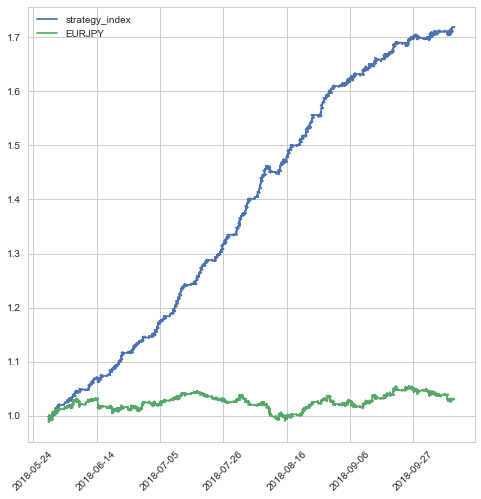

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,8))
plt.plot(data['strategy_index'])
plt.plot(data['open']/126.19, label='EURJPY')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

策略缺陷：毕竟是高频交易，开仓频率可能较大，会产生较多的手续费与税费